# CNNs for Heart Rate Estimation and Human Activity Recognition in Wrist Worn Sensing Applications


This is code for reproducing the HAR results shown in the paper presented at the WristSense workshop as part of PerCom 2020. \\

***NB***: Please be aware this Notebook is simply the [```retrain.py```](https://github.com/googlecodelabs/tensorflow-for-poets-2) file copied into the cells below. This script was designed to run on TensorFlow 1.x. Since the deprecation of TF 1.x in January 2020 the authors have uploaded "a modern, simplified approach to training this model" which can be found [here](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb). 

## Data

The data was collected by [D. Jarchi and A. Casson (2017)](https://www.mdpi.com/2306-5729/2/1/1) and downloaded from [PhysioNet](https://physionet.org/content/wrist/1.0.0/). \\

The data was prepared for this script using the ```HAR.ipynb``` Notebook.

## If using Google Colaboratory

You can run this notebook on Colab using the following cell to mount your drive and install some dependencies

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive') # 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Retrain

The parameter Defaults can be changed in this cell to what the user likes. All parameters except number of iterations were kept the same.

 ```--how_many_training_steps``` changed from 10k to 4k.

 You will need to edit the directories used here also.

In [0]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
# NOTICE: This work was derived from tensorflow/examples/image_retraining
# and modified to use TensorFlow Hub modules.

# pylint: disable=line-too-long
r"""Simple transfer learning with image modules from TensorFlow Hub.

This example shows how to train an image classifier based on any
TensorFlow Hub module that computes image feature vectors. By default,
it uses the feature vectors computed by Inception V3 trained on ImageNet.
See https://github.com/tensorflow/hub/blob/master/docs/modules/image.md
for more options.

The top layer receives as input a 2048-dimensional vector (assuming
Inception V3) for each image. We train a softmax layer on top of this
representation. If the softmax layer contains N labels, this corresponds
to learning N + 2048*N model parameters for the biases and weights.

Here's an example, which assumes you have a folder containing class-named
subfolders, each full of images for each label. The example folder flower_photos
should have a structure like this:

~/flower_photos/daisy/photo1.jpg
~/flower_photos/daisy/photo2.jpg
...
~/flower_photos/rose/anotherphoto77.jpg
...
~/flower_photos/sunflower/somepicture.jpg

The subfolder names are important, since they define what label is applied to
each image, but the filenames themselves don't matter. (For a working example,
download http://download.tensorflow.org/example_images/flower_photos.tgz
and run  tar xzf flower_photos.tgz  to unpack it.)

Once your images are prepared, and you have pip-installed tensorflow-hub and
a sufficiently recent version of tensorflow, you can run the training with a
command like this:

```bash
python retrain.py --image_dir ~/flower_photos
```

You can replace the image_dir argument with any folder containing subfolders of
images. The label for each image is taken from the name of the subfolder it's
in.

This produces a new model file that can be loaded and run by any TensorFlow
program, for example the tensorflow/examples/label_image sample code.

By default this script will use the highly accurate, but comparatively large and
slow Inception V3 model architecture. It's recommended that you start with this
to validate that you have gathered good training data, but if you want to deploy
on resource-limited platforms, you can try the `--tfhub_module` flag with a
Mobilenet model. For more information on Mobilenet, see
https://research.googleblog.com/2017/06/mobilenets-open-source-models-for.html

For example:

Run floating-point version of Mobilenet:

```bash
python retrain.py --image_dir ~/flower_photos \
    --tfhub_module https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/1
```

Run Mobilenet, instrumented for quantization:

```bash
python retrain.py --image_dir ~/flower_photos/ \
    --tfhub_module https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/quantops/feature_vector/1
```

These instrumented models can be converted to fully quantized mobile models via
TensorFlow Lite.

There are different Mobilenet models to choose from, with a variety of file
size and latency options.
  - The first number can be '100', '075', '050', or '025' to control the number
    of neurons (activations of hidden layers); the number of weights (and hence
    to some extent the file size and speed) shrinks with the square of that
    fraction.
  - The second number is the input image size. You can choose '224', '192',
    '160', or '128', with smaller sizes giving faster speeds.

To use with TensorBoard:

By default, this script will log summaries to /tmp/retrain_logs directory

Visualize the summaries with this command:

tensorboard --logdir /tmp/retrain_logs

To use with Tensorflow Serving, run this tool with --saved_model_dir set
to some increasingly numbered export location under the model base path, e.g.:

```bash
python retrain.py (... other args as before ...) \
    --saved_model_dir=/tmp/saved_models/$(date +%s)/
tensorflow_model_server --port=9000 --model_name=my_image_classifier \
    --model_base_path=/tmp/saved_models/
```
"""
# pylint: enable=line-too-long

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import collections
from datetime import datetime
import hashlib
import os.path
import random
import re
import sys

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

FLAGS = None

MAX_NUM_IMAGES_PER_CLASS = 2 ** 27 - 1  # ~134M
#retrained_models/

# The location where variable checkpoints will be stored.
CHECKPOINT_NAME = '/content/drive/My Drive/.../tf_files/retraining/Inception/retrain_checkpoint'

# A module is understood as instrumented for quantization with TF-Lite
# if it contains any of these ops.
FAKE_QUANT_OPS = ('FakeQuantWithMinMaxVars',
                  'FakeQuantWithMinMaxVarsPerChannel')


def create_image_lists(image_dir, testing_percentage, validation_percentage):
  """Builds a list of training images from the file system.

  Analyzes the sub folders in the image directory, splits them into stable
  training, testing, and validation sets, and returns a data structure
  describing the lists of images for each label and their paths.

  Args:
    image_dir: String path to a folder containing subfolders of images.
    testing_percentage: Integer percentage of the images to reserve for tests.
    validation_percentage: Integer percentage of images reserved for validation.

  Returns:
    An OrderedDict containing an entry for each label subfolder, with images
    split into training, testing, and validation sets within each label.
    The order of items defines the class indices.
  """
  if not tf.gfile.Exists(image_dir):
    tf.logging.error("Image directory '" + image_dir + "' not found.")
    return None
  result = collections.OrderedDict()
  sub_dirs = sorted(x[0] for x in tf.gfile.Walk(image_dir))
  # The root directory comes first, so skip it.
  is_root_dir = True
  for sub_dir in sub_dirs:
    if is_root_dir:
      is_root_dir = False
      continue
    extensions = sorted(set(os.path.normcase(ext)  # Smash case on Windows.
                            for ext in ['JPEG', 'JPG', 'jpeg', 'jpg', 'png']))
    file_list = []
    dir_name = os.path.basename(sub_dir)
    if dir_name == image_dir:
      continue
    tf.logging.info("Looking for images in '" + dir_name + "'")
    for extension in extensions:
      file_glob = os.path.join(image_dir, dir_name, '*.' + extension)
      file_list.extend(tf.gfile.Glob(file_glob))
    if not file_list:
      tf.logging.warning('No files found')
      continue
    if len(file_list) < 20:
      tf.logging.warning(
          'WARNING: Folder has less than 20 images, which may cause issues.')
    elif len(file_list) > MAX_NUM_IMAGES_PER_CLASS:
      tf.logging.warning(
          'WARNING: Folder {} has more than {} images. Some images will '
          'never be selected.'.format(dir_name, MAX_NUM_IMAGES_PER_CLASS))
    label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower())
    training_images = []
    testing_images = []
    validation_images = []
    for file_name in file_list:
      base_name = os.path.basename(file_name)
      # We want to ignore anything after '_nohash_' in the file name when
      # deciding which set to put an image in, the data set creator has a way of
      # grouping photos that are close variations of each other. For example
      # this is used in the plant disease data set to group multiple pictures of
      # the same leaf.
      hash_name = re.sub(r'_nohash_.*$', '', file_name)
      # This looks a bit magical, but we need to decide whether this file should
      # go into the training, testing, or validation sets, and we want to keep
      # existing files in the same set even if more files are subsequently
      # added.
      # To do that, we need a stable way of deciding based on just the file name
      # itself, so we do a hash of that and then use that to generate a
      # probability value that we use to assign it.
      hash_name_hashed = hashlib.sha1(tf.compat.as_bytes(hash_name)).hexdigest()
      percentage_hash = ((int(hash_name_hashed, 16) %
                          (MAX_NUM_IMAGES_PER_CLASS + 1)) *
                         (100.0 / MAX_NUM_IMAGES_PER_CLASS))
      if percentage_hash < validation_percentage:
        validation_images.append(base_name)
      elif percentage_hash < (testing_percentage + validation_percentage):
        testing_images.append(base_name)
      else:
        training_images.append(base_name)
    result[label_name] = {
        'dir': dir_name,
        'training': training_images,
        'testing': testing_images,
        'validation': validation_images,
    }
  return result


def get_image_path(image_lists, label_name, index, image_dir, category):
  """Returns a path to an image for a label at the given index.

  Args:
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Int offset of the image we want. This will be moduloed by the
    available number of images for the label, so it can be arbitrarily large.
    image_dir: Root folder string of the subfolders containing the training
    images.
    category: Name string of set to pull images from - training, testing, or
    validation.

  Returns:
    File system path string to an image that meets the requested parameters.

  """
  if label_name not in image_lists:
    tf.logging.fatal('Label does not exist %s.', label_name)
  label_lists = image_lists[label_name]
  if category not in label_lists:
    tf.logging.fatal('Category does not exist %s.', category)
  category_list = label_lists[category]
  if not category_list:
    tf.logging.fatal('Label %s has no images in the category %s.',
                     label_name, category)
  mod_index = index % len(category_list)
  base_name = category_list[mod_index]
  sub_dir = label_lists['dir']
  full_path = os.path.join(image_dir, sub_dir, base_name)
  return full_path


def get_bottleneck_path(image_lists, label_name, index, bottleneck_dir,
                        category, module_name):
  """Returns a path to a bottleneck file for a label at the given index.

  Args:
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Integer offset of the image we want. This will be moduloed by the
    available number of images for the label, so it can be arbitrarily large.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    category: Name string of set to pull images from - training, testing, or
    validation.
    module_name: The name of the image module being used.

  Returns:
    File system path string to an image that meets the requested parameters.
  """
  module_name = (module_name.replace('://', '~')  # URL scheme.
                 .replace('/', '~')  # URL and Unix paths.
                 .replace(':', '~').replace('\\', '~'))  # Windows paths.
  return get_image_path(image_lists, label_name, index, bottleneck_dir,
                        category) + '_' + module_name + '.txt'


def create_module_graph(module_spec):
  """Creates a graph and loads Hub Module into it.

  Args:
    module_spec: the hub.ModuleSpec for the image module being used.

  Returns:
    graph: the tf.Graph that was created.
    bottleneck_tensor: the bottleneck values output by the module.
    resized_input_tensor: the input images, resized as expected by the module.
    wants_quantization: a boolean, whether the module has been instrumented
      with fake quantization ops.
  """
  height, width = hub.get_expected_image_size(module_spec)
  with tf.Graph().as_default() as graph:
    resized_input_tensor = tf.placeholder(tf.float32, [None, height, width, 3])
    m = hub.Module(module_spec)
    bottleneck_tensor = m(resized_input_tensor)
    wants_quantization = any(node.op in FAKE_QUANT_OPS
                             for node in graph.as_graph_def().node)
  return graph, bottleneck_tensor, resized_input_tensor, wants_quantization


def run_bottleneck_on_image(sess, image_data, image_data_tensor,
                            decoded_image_tensor, resized_input_tensor,
                            bottleneck_tensor):
  """Runs inference on an image to extract the 'bottleneck' summary layer.

  Args:
    sess: Current active TensorFlow Session.
    image_data: String of raw JPEG data.
    image_data_tensor: Input data layer in the graph.
    decoded_image_tensor: Output of initial image resizing and preprocessing.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: Layer before the final softmax.

  Returns:
    Numpy array of bottleneck values.
  """
  # First decode the JPEG image, resize it, and rescale the pixel values.
  resized_input_values = sess.run(decoded_image_tensor,
                                  {image_data_tensor: image_data})
  # Then run it through the recognition network.
  bottleneck_values = sess.run(bottleneck_tensor,
                               {resized_input_tensor: resized_input_values})
  bottleneck_values = np.squeeze(bottleneck_values)
  return bottleneck_values


def ensure_dir_exists(dir_name):
  """Makes sure the folder exists on disk.

  Args:
    dir_name: Path string to the folder we want to create.
  """
  if not os.path.exists(dir_name):
    os.makedirs(dir_name)


def create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, jpeg_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor):
  """Create a single bottleneck file."""
  #tf.logging.info('Creating bottleneck at ' + bottleneck_path)
  image_path = get_image_path(image_lists, label_name, index,
                              image_dir, category)
  if not tf.gfile.Exists(image_path):
    tf.logging.fatal('File does not exist %s', image_path)
  image_data = tf.gfile.FastGFile(image_path, 'rb').read()
  try:
    bottleneck_values = run_bottleneck_on_image(
        sess, image_data, jpeg_data_tensor, decoded_image_tensor,
        resized_input_tensor, bottleneck_tensor)
  except Exception as e:
    raise RuntimeError('Error during processing file %s (%s)' % (image_path,
                                                                 str(e)))
  bottleneck_string = ','.join(str(x) for x in bottleneck_values)
  with open(bottleneck_path, 'w') as bottleneck_file:
    bottleneck_file.write(bottleneck_string)


def get_or_create_bottleneck(sess, image_lists, label_name, index, image_dir,
                             category, bottleneck_dir, jpeg_data_tensor,
                             decoded_image_tensor, resized_input_tensor,
                             bottleneck_tensor, module_name):
  """Retrieves or calculates bottleneck values for an image.

  If a cached version of the bottleneck data exists on-disk, return that,
  otherwise calculate the data and save it to disk for future use.

  Args:
    sess: The current active TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Integer offset of the image we want. This will be modulo-ed by the
    available number of images for the label, so it can be arbitrarily large.
    image_dir: Root folder string of the subfolders containing the training
    images.
    category: Name string of which set to pull images from - training, testing,
    or validation.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    jpeg_data_tensor: The tensor to feed loaded jpeg data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The output tensor for the bottleneck values.
    module_name: The name of the image module being used.

  Returns:
    Numpy array of values produced by the bottleneck layer for the image.
  """
  label_lists = image_lists[label_name]
  sub_dir = label_lists['dir']
  sub_dir_path = os.path.join(bottleneck_dir, sub_dir)
  ensure_dir_exists(sub_dir_path)
  bottleneck_path = get_bottleneck_path(image_lists, label_name, index,
                                        bottleneck_dir, category, module_name)
  if not os.path.exists(bottleneck_path):
    create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, jpeg_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor)
  with open(bottleneck_path, 'r') as bottleneck_file:
    bottleneck_string = bottleneck_file.read()
  did_hit_error = False
  try:
    bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
  except ValueError:
    tf.logging.warning('Invalid float found, recreating bottleneck')
    did_hit_error = True
  if did_hit_error:
    create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, jpeg_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor)
    with open(bottleneck_path, 'r') as bottleneck_file:
      bottleneck_string = bottleneck_file.read()
    # Allow exceptions to propagate here, since they shouldn't happen after a
    # fresh creation
    bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
  return bottleneck_values


def cache_bottlenecks(sess, image_lists, image_dir, bottleneck_dir,
                      jpeg_data_tensor, decoded_image_tensor,
                      resized_input_tensor, bottleneck_tensor, module_name):
  """Ensures all the training, testing, and validation bottlenecks are cached.

  Because we're likely to read the same image multiple times (if there are no
  distortions applied during training) it can speed things up a lot if we
  calculate the bottleneck layer values once for each image during
  preprocessing, and then just read those cached values repeatedly during
  training. Here we go through all the images we've found, calculate those
  values, and save them off.

  Args:
    sess: The current active TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    image_dir: Root folder string of the subfolders containing the training
    images.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    jpeg_data_tensor: Input tensor for jpeg data from file.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The penultimate output layer of the graph.
    module_name: The name of the image module being used.

  Returns:
    Nothing.
  """
  how_many_bottlenecks = 0
  ensure_dir_exists(bottleneck_dir)
  for label_name, label_lists in image_lists.items():
    for category in ['training', 'testing', 'validation']:
      category_list = label_lists[category]
      for index, unused_base_name in enumerate(category_list):
        get_or_create_bottleneck(
            sess, image_lists, label_name, index, image_dir, category,
            bottleneck_dir, jpeg_data_tensor, decoded_image_tensor,
            resized_input_tensor, bottleneck_tensor, module_name)

        how_many_bottlenecks += 1
        if how_many_bottlenecks % 300 == 0:
          tf.logging.info(
              str(how_many_bottlenecks) + ' bottleneck files created.')


def get_random_cached_bottlenecks(sess, image_lists, how_many, category,
                                  bottleneck_dir, image_dir, jpeg_data_tensor,
                                  decoded_image_tensor, resized_input_tensor,
                                  bottleneck_tensor, module_name):
  """Retrieves bottleneck values for cached images.

  If no distortions are being applied, this function can retrieve the cached
  bottleneck values directly from disk for images. It picks a random set of
  images from the specified category.

  Args:
    sess: Current TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    how_many: If positive, a random sample of this size will be chosen.
    If negative, all bottlenecks will be retrieved.
    category: Name string of which set to pull from - training, testing, or
    validation.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    image_dir: Root folder string of the subfolders containing the training
    images.
    jpeg_data_tensor: The layer to feed jpeg image data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.
    module_name: The name of the image module being used.

  Returns:
    List of bottleneck arrays, their corresponding ground truths, and the
    relevant filenames.
  """
  class_count = len(image_lists.keys())
  bottlenecks = []
  ground_truths = []
  filenames = []
  if how_many >= 0:
    # Retrieve a random sample of bottlenecks.
    for unused_i in range(how_many):
      label_index = random.randrange(class_count)
      label_name = list(image_lists.keys())[label_index]
      image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
      image_name = get_image_path(image_lists, label_name, image_index,
                                  image_dir, category)
      bottleneck = get_or_create_bottleneck(
          sess, image_lists, label_name, image_index, image_dir, category,
          bottleneck_dir, jpeg_data_tensor, decoded_image_tensor,
          resized_input_tensor, bottleneck_tensor, module_name)
      bottlenecks.append(bottleneck)
      ground_truths.append(label_index)
      filenames.append(image_name)
  else:
    # Retrieve all bottlenecks.
    for label_index, label_name in enumerate(image_lists.keys()):
      for image_index, image_name in enumerate(
          image_lists[label_name][category]):
        image_name = get_image_path(image_lists, label_name, image_index,
                                    image_dir, category)
        bottleneck = get_or_create_bottleneck(
            sess, image_lists, label_name, image_index, image_dir, category,
            bottleneck_dir, jpeg_data_tensor, decoded_image_tensor,
            resized_input_tensor, bottleneck_tensor, module_name)
        bottlenecks.append(bottleneck)
        ground_truths.append(label_index)
        filenames.append(image_name)
  return bottlenecks, ground_truths, filenames


def get_random_distorted_bottlenecks(
    sess, image_lists, how_many, category, image_dir, input_jpeg_tensor,
    distorted_image, resized_input_tensor, bottleneck_tensor):
  """Retrieves bottleneck values for training images, after distortions.

  If we're training with distortions like crops, scales, or flips, we have to
  recalculate the full model for every image, and so we can't use cached
  bottleneck values. Instead we find random images for the requested category,
  run them through the distortion graph, and then the full graph to get the
  bottleneck results for each.

  Args:
    sess: Current TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    how_many: The integer number of bottleneck values to return.
    category: Name string of which set of images to fetch - training, testing,
    or validation.
    image_dir: Root folder string of the subfolders containing the training
    images.
    input_jpeg_tensor: The input layer we feed the image data to.
    distorted_image: The output node of the distortion graph.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.

  Returns:
    List of bottleneck arrays and their corresponding ground truths.
  """
  class_count = len(image_lists.keys())
  bottlenecks = []
  ground_truths = []
  for unused_i in range(how_many):
    label_index = random.randrange(class_count)
    label_name = list(image_lists.keys())[label_index]
    image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
    image_path = get_image_path(image_lists, label_name, image_index, image_dir,
                                category)
    if not tf.gfile.Exists(image_path):
      tf.logging.fatal('File does not exist %s', image_path)
    jpeg_data = tf.gfile.FastGFile(image_path, 'rb').read()
    # Note that we materialize the distorted_image_data as a numpy array before
    # sending running inference on the image. This involves 2 memory copies and
    # might be optimized in other implementations.
    distorted_image_data = sess.run(distorted_image,
                                    {input_jpeg_tensor: jpeg_data})
    bottleneck_values = sess.run(bottleneck_tensor,
                                 {resized_input_tensor: distorted_image_data})
    bottleneck_values = np.squeeze(bottleneck_values)
    bottlenecks.append(bottleneck_values)
    ground_truths.append(label_index)
  return bottlenecks, ground_truths


def should_distort_images(flip_left_right, random_crop, random_scale,
                          random_brightness):
  """Whether any distortions are enabled, from the input flags.

  Args:
    flip_left_right: Boolean whether to randomly mirror images horizontally.
    random_crop: Integer percentage setting the total margin used around the
    crop box.
    random_scale: Integer percentage of how much to vary the scale by.
    random_brightness: Integer range to randomly multiply the pixel values by.

  Returns:
    Boolean value indicating whether any distortions should be applied.
  """
  return (flip_left_right or (random_crop != 0) or (random_scale != 0) or
          (random_brightness != 0))


def add_input_distortions(flip_left_right, random_crop, random_scale,
                          random_brightness, module_spec):
  """Creates the operations to apply the specified distortions.

  During training it can help to improve the results if we run the images
  through simple distortions like crops, scales, and flips. These reflect the
  kind of variations we expect in the real world, and so can help train the
  model to cope with natural data more effectively. Here we take the supplied
  parameters and construct a network of operations to apply them to an image.

  Cropping
  ~~~~~~~~

  Cropping is done by placing a bounding box at a random position in the full
  image. The cropping parameter controls the size of that box relative to the
  input image. If it's zero, then the box is the same size as the input and no
  cropping is performed. If the value is 50%, then the crop box will be half the
  width and height of the input. In a diagram it looks like this:

  <       width         >
  +---------------------+
  |                     |
  |   width - crop%     |
  |    <      >         |
  |    +------+         |
  |    |      |         |
  |    |      |         |
  |    |      |         |
  |    +------+         |
  |                     |
  |                     |
  +---------------------+

  Scaling
  ~~~~~~~

  Scaling is a lot like cropping, except that the bounding box is always
  centered and its size varies randomly within the given range. For example if
  the scale percentage is zero, then the bounding box is the same size as the
  input and no scaling is applied. If it's 50%, then the bounding box will be in
  a random range between half the width and height and full size.

  Args:
    flip_left_right: Boolean whether to randomly mirror images horizontally.
    random_crop: Integer percentage setting the total margin used around the
    crop box.
    random_scale: Integer percentage of how much to vary the scale by.
    random_brightness: Integer range to randomly multiply the pixel values by.
    graph.
    module_spec: The hub.ModuleSpec for the image module being used.

  Returns:
    The jpeg input layer and the distorted result tensor.
  """
  input_height, input_width = hub.get_expected_image_size(module_spec)
  input_depth = hub.get_num_image_channels(module_spec)
  jpeg_data = tf.placeholder(tf.string, name='DistortJPGInput')
  decoded_image = tf.image.decode_jpeg(jpeg_data, channels=input_depth)
  # Convert from full range of uint8 to range [0,1] of float32.
  decoded_image_as_float = tf.image.convert_image_dtype(decoded_image,
                                                        tf.float32)
  decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
  margin_scale = 1.0 + (random_crop / 100.0)
  resize_scale = 1.0 + (random_scale / 100.0)
  margin_scale_value = tf.constant(margin_scale)
  resize_scale_value = tf.random_uniform(shape=[],
                                         minval=1.0,
                                         maxval=resize_scale)
  scale_value = tf.multiply(margin_scale_value, resize_scale_value)
  precrop_width = tf.multiply(scale_value, input_width)
  precrop_height = tf.multiply(scale_value, input_height)
  precrop_shape = tf.stack([precrop_height, precrop_width])
  precrop_shape_as_int = tf.cast(precrop_shape, dtype=tf.int32)
  precropped_image = tf.image.resize_bilinear(decoded_image_4d,
                                              precrop_shape_as_int)
  precropped_image_3d = tf.squeeze(precropped_image, axis=[0])
  cropped_image = tf.random_crop(precropped_image_3d,
                                 [input_height, input_width, input_depth])
  if flip_left_right:
    flipped_image = tf.image.random_flip_left_right(cropped_image)
  else:
    flipped_image = cropped_image
  brightness_min = 1.0 - (random_brightness / 100.0)
  brightness_max = 1.0 + (random_brightness / 100.0)
  brightness_value = tf.random_uniform(shape=[],
                                       minval=brightness_min,
                                       maxval=brightness_max)
  brightened_image = tf.multiply(flipped_image, brightness_value)
  distort_result = tf.expand_dims(brightened_image, 0, name='DistortResult')
  return jpeg_data, distort_result


def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)


def add_final_retrain_ops(class_count, final_tensor_name, bottleneck_tensor,
                          quantize_layer, is_training):
  """Adds a new softmax and fully-connected layer for training and eval.

  We need to retrain the top layer to identify our new classes, so this function
  adds the right operations to the graph, along with some variables to hold the
  weights, and then sets up all the gradients for the backward pass.

  The set up for the softmax and fully-connected layers is based on:
  https://www.tensorflow.org/tutorials/mnist/beginners/index.html

  Args:
    class_count: Integer of how many categories of things we're trying to
        recognize.
    final_tensor_name: Name string for the new final node that produces results.
    bottleneck_tensor: The output of the main CNN graph.
    quantize_layer: Boolean, specifying whether the newly added layer should be
        instrumented for quantization with TF-Lite.
    is_training: Boolean, specifying whether the newly add layer is for training
        or eval.

  Returns:
    The tensors for the training and cross entropy results, and tensors for the
    bottleneck input and ground truth input.
  """
  batch_size, bottleneck_tensor_size = bottleneck_tensor.get_shape().as_list()
  assert batch_size is None, 'We want to work with arbitrary batch size.'
  with tf.name_scope('input'):
    bottleneck_input = tf.placeholder_with_default(
        bottleneck_tensor,
        shape=[batch_size, bottleneck_tensor_size],
        name='BottleneckInputPlaceholder')

    ground_truth_input = tf.placeholder(
        tf.int64, [batch_size], name='GroundTruthInput')

  # Organizing the following ops so they are easier to see in TensorBoard.
  layer_name = 'final_retrain_ops'
  with tf.name_scope(layer_name):
    with tf.name_scope('weights'):
      initial_value = tf.truncated_normal(
          [bottleneck_tensor_size, class_count], stddev=0.001)
      layer_weights = tf.Variable(initial_value, name='final_weights')
      variable_summaries(layer_weights)

    with tf.name_scope('biases'):
      layer_biases = tf.Variable(tf.zeros([class_count]), name='final_biases')
      variable_summaries(layer_biases)

    with tf.name_scope('Wx_plus_b'):
      logits = tf.matmul(bottleneck_input, layer_weights) + layer_biases
      tf.summary.histogram('pre_activations', logits)

  final_tensor = tf.nn.softmax(logits, name=final_tensor_name)

  # The tf.contrib.quantize functions rewrite the graph in place for
  # quantization. The imported model graph has already been rewritten, so upon
  # calling these rewrites, only the newly added final layer will be
  # transformed.
  if quantize_layer:
    if is_training:
      tf.contrib.quantize.create_training_graph()
    else:
      tf.contrib.quantize.create_eval_graph()

  tf.summary.histogram('activations', final_tensor)

  # If this is an eval graph, we don't need to add loss ops or an optimizer.
  if not is_training:
    return None, None, bottleneck_input, ground_truth_input, final_tensor

  with tf.name_scope('cross_entropy'):
    cross_entropy_mean = tf.losses.sparse_softmax_cross_entropy(
        labels=ground_truth_input, logits=logits)

  tf.summary.scalar('cross_entropy', cross_entropy_mean)

  with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(FLAGS.learning_rate)
    train_step = optimizer.minimize(cross_entropy_mean)

  return (train_step, cross_entropy_mean, bottleneck_input, ground_truth_input,
          final_tensor)


def add_evaluation_step(result_tensor, ground_truth_tensor):
  """Inserts the operations we need to evaluate the accuracy of our results.

  Args:
    result_tensor: The new final node that produces results.
    ground_truth_tensor: The node we feed ground truth data
    into.

  Returns:
    Tuple of (evaluation step, prediction).
  """
  with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
      prediction = tf.argmax(result_tensor, 1)
      correct_prediction = tf.equal(prediction, ground_truth_tensor)
    with tf.name_scope('accuracy'):
      evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  tf.summary.scalar('accuracy', evaluation_step)
  return evaluation_step, prediction


def run_final_eval(train_session, module_spec, class_count, image_lists,
                   jpeg_data_tensor, decoded_image_tensor,
                   resized_image_tensor, bottleneck_tensor):
  """Runs a final evaluation on an eval graph using the test data set.

  Args:
    train_session: Session for the train graph with the tensors below.
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: Number of classes
    image_lists: OrderedDict of training images for each label.
    jpeg_data_tensor: The layer to feed jpeg image data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_image_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.
  """
  test_bottlenecks, test_ground_truth, test_filenames = (
      get_random_cached_bottlenecks(train_session, image_lists,
                                    FLAGS.test_batch_size,
                                    'testing', FLAGS.bottleneck_dir,
                                    FLAGS.image_dir, jpeg_data_tensor,
                                    decoded_image_tensor, resized_image_tensor,
                                    bottleneck_tensor, FLAGS.tfhub_module))

  (eval_session, _, bottleneck_input, ground_truth_input, evaluation_step,
   prediction) = build_eval_session(module_spec, class_count)
  test_accuracy, predictions = eval_session.run(
      [evaluation_step, prediction],
      feed_dict={
          bottleneck_input: test_bottlenecks,
          ground_truth_input: test_ground_truth
      })
  tf.logging.info('Final test accuracy = %.1f%% (N=%d)' %
                  (test_accuracy * 100, len(test_bottlenecks)))

  if FLAGS.print_misclassified_test_images:
    tf.logging.info('=== MISCLASSIFIED TEST IMAGES ===')
    for i, test_filename in enumerate(test_filenames):
      if predictions[i] != test_ground_truth[i]:
        tf.logging.info('%70s  %s' % (test_filename,
                                      list(image_lists.keys())[predictions[i]]))


def build_eval_session(module_spec, class_count):
  """Builds an restored eval session without train operations for exporting.

  Args:
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: Number of classes

  Returns:
    Eval session containing the restored eval graph.
    The bottleneck input, ground truth, eval step, and prediction tensors.
  """
  # If quantized, we need to create the correct eval graph for exporting.
  eval_graph, bottleneck_tensor, resized_input_tensor, wants_quantization = (
      create_module_graph(module_spec))

  eval_sess = tf.Session(graph=eval_graph)
  with eval_graph.as_default():
    # Add the new layer for exporting.
    (_, _, bottleneck_input,
     ground_truth_input, final_tensor) = add_final_retrain_ops(
         class_count, FLAGS.final_tensor_name, bottleneck_tensor,
         wants_quantization, is_training=False)

    # Now we need to restore the values from the training graph to the eval
    # graph.
    tf.train.Saver().restore(eval_sess, CHECKPOINT_NAME)

    evaluation_step, prediction = add_evaluation_step(final_tensor,
                                                      ground_truth_input)

  return (eval_sess, resized_input_tensor, bottleneck_input, ground_truth_input,
          evaluation_step, prediction)


def save_graph_to_file(graph_file_name, module_spec, class_count):
  """Saves an graph to file, creating a valid quantized one if necessary."""
  sess, _, _, _, _, _ = build_eval_session(module_spec, class_count)
  graph = sess.graph

  output_graph_def = tf.graph_util.convert_variables_to_constants(
      sess, graph.as_graph_def(), [FLAGS.final_tensor_name])

  with tf.gfile.FastGFile(graph_file_name, 'wb') as f:
    f.write(output_graph_def.SerializeToString())


def prepare_file_system():
  # Set up the directory we'll write summaries to for TensorBoard
  if tf.gfile.Exists(FLAGS.summaries_dir):
    tf.gfile.DeleteRecursively(FLAGS.summaries_dir)
  tf.gfile.MakeDirs(FLAGS.summaries_dir)
  if FLAGS.intermediate_store_frequency > 0:
    ensure_dir_exists(FLAGS.intermediate_output_graphs_dir)
  return


def add_jpeg_decoding(module_spec):
  """Adds operations that perform JPEG decoding and resizing to the graph..

  Args:
    module_spec: The hub.ModuleSpec for the image module being used.

  Returns:
    Tensors for the node to feed JPEG data into, and the output of the
      preprocessing steps.
  """
  input_height, input_width = hub.get_expected_image_size(module_spec)
  input_depth = hub.get_num_image_channels(module_spec)
  jpeg_data = tf.placeholder(tf.string, name='DecodeJPGInput')
  decoded_image = tf.image.decode_jpeg(jpeg_data, channels=input_depth)
  # Convert from full range of uint8 to range [0,1] of float32.
  decoded_image_as_float = tf.image.convert_image_dtype(decoded_image,
                                                        tf.float32)
  decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
  resize_shape = tf.stack([input_height, input_width])
  resize_shape_as_int = tf.cast(resize_shape, dtype=tf.int32)
  resized_image = tf.image.resize_bilinear(decoded_image_4d,
                                           resize_shape_as_int)
  return jpeg_data, resized_image


def export_model(module_spec, class_count, saved_model_dir):
  """Exports model for serving.

  Args:
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: The number of classes.
    saved_model_dir: Directory in which to save exported model and variables.
  """
  # The SavedModel should hold the eval graph.
  sess, in_image, _, _, _, _ = build_eval_session(module_spec, class_count)
  with sess.graph.as_default() as graph:
    tf.saved_model.simple_save(
        sess,
        saved_model_dir,
        inputs={'image': in_image},
        outputs={'prediction': graph.get_tensor_by_name('final_result:0')},
        legacy_init_op=tf.group(tf.tables_initializer(), name='legacy_init_op')
    )


def main(_):
  # Needed to make sure the logging output is visible.
  # See https://github.com/tensorflow/tensorflow/issues/3047
  tf.logging.set_verbosity(tf.logging.INFO)

  if not FLAGS.image_dir:
    tf.logging.error('Must set flag --image_dir.')
    return -1

  # Prepare necessary directories that can be used during training
  prepare_file_system()

  # Look at the folder structure, and create lists of all the images.
  image_lists = create_image_lists(FLAGS.image_dir, FLAGS.testing_percentage,
                                   FLAGS.validation_percentage)
  class_count = len(image_lists.keys())
  if class_count == 0:
    tf.logging.error('No valid folders of images found at ' + FLAGS.image_dir)
    return -1
  if class_count == 1:
    tf.logging.error('Only one valid folder of images found at ' +
                     FLAGS.image_dir +
                     ' - multiple classes are needed for classification.')
    return -1

  # See if the command-line flags mean we're applying any distortions.
  do_distort_images = should_distort_images(
      FLAGS.flip_left_right, FLAGS.random_crop, FLAGS.random_scale,
      FLAGS.random_brightness)

  # Set up the pre-trained graph.
  module_spec = hub.load_module_spec(FLAGS.tfhub_module)
  graph, bottleneck_tensor, resized_image_tensor, wants_quantization = (
      create_module_graph(module_spec))

  # Add the new layer that we'll be training.
  with graph.as_default():
    (train_step, cross_entropy, bottleneck_input,
     ground_truth_input, final_tensor) = add_final_retrain_ops(
         class_count, FLAGS.final_tensor_name, bottleneck_tensor,
         wants_quantization, is_training=True)

  with tf.Session(graph=graph) as sess:
    # Initialize all weights: for the module to their pretrained values,
    # and for the newly added retraining layer to random initial values.
    init = tf.global_variables_initializer()
    sess.run(init)

    # Set up the image decoding sub-graph.
    jpeg_data_tensor, decoded_image_tensor = add_jpeg_decoding(module_spec)

    if do_distort_images:
      # We will be applying distortions, so set up the operations we'll need.
      (distorted_jpeg_data_tensor,
       distorted_image_tensor) = add_input_distortions(
           FLAGS.flip_left_right, FLAGS.random_crop, FLAGS.random_scale,
           FLAGS.random_brightness, module_spec)
    else:
      # We'll make sure we've calculated the 'bottleneck' image summaries and
      # cached them on disk.
      cache_bottlenecks(sess, image_lists, FLAGS.image_dir,
                        FLAGS.bottleneck_dir, jpeg_data_tensor,
                        decoded_image_tensor, resized_image_tensor,
                        bottleneck_tensor, FLAGS.tfhub_module)

    # Create the operations we need to evaluate the accuracy of our new layer.
    evaluation_step, _ = add_evaluation_step(final_tensor, ground_truth_input)

    # Merge all the summaries and write them out to the summaries_dir
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(FLAGS.summaries_dir + '/train',
                                         sess.graph)

    validation_writer = tf.summary.FileWriter(
        FLAGS.summaries_dir + '/validation')

    # Create a train saver that is used to restore values into an eval graph
    # when exporting models.
    train_saver = tf.train.Saver()

    # Run the training for as many cycles as requested on the command line.
    for i in range(FLAGS.how_many_training_steps):
      # Get a batch of input bottleneck values, either calculated fresh every
      # time with distortions applied, or from the cache stored on disk.
      if do_distort_images:
        (train_bottlenecks,
         train_ground_truth) = get_random_distorted_bottlenecks(
             sess, image_lists, FLAGS.train_batch_size, 'training',
             FLAGS.image_dir, distorted_jpeg_data_tensor,
             distorted_image_tensor, resized_image_tensor, bottleneck_tensor)
      else:
        (train_bottlenecks,
         train_ground_truth, _) = get_random_cached_bottlenecks(
             sess, image_lists, FLAGS.train_batch_size, 'training',
             FLAGS.bottleneck_dir, FLAGS.image_dir, jpeg_data_tensor,
             decoded_image_tensor, resized_image_tensor, bottleneck_tensor,
             FLAGS.tfhub_module)
      # Feed the bottlenecks and ground truth into the graph, and run a training
      # step. Capture training summaries for TensorBoard with the `merged` op.
      train_summary, _ = sess.run(
          [merged, train_step],
          feed_dict={bottleneck_input: train_bottlenecks,
                     ground_truth_input: train_ground_truth})
      train_writer.add_summary(train_summary, i)

      # Every so often, print out how well the graph is training.
      is_last_step = (i + 1 == FLAGS.how_many_training_steps)
      if (i % FLAGS.eval_step_interval) == 0 or is_last_step:
        train_accuracy, cross_entropy_value = sess.run(
            [evaluation_step, cross_entropy],
            feed_dict={bottleneck_input: train_bottlenecks,
                       ground_truth_input: train_ground_truth})
        tf.logging.info('%s: Step %d: Train accuracy = %.1f%%' %
                        (datetime.now(), i, train_accuracy * 100))
        tf.logging.info('%s: Step %d: Cross entropy = %f' %
                        (datetime.now(), i, cross_entropy_value))
        # TODO: Make this use an eval graph, to avoid quantization
        # moving averages being updated by the validation set, though in
        # practice this makes a negligable difference.
        validation_bottlenecks, validation_ground_truth, _ = (
            get_random_cached_bottlenecks(
                sess, image_lists, FLAGS.validation_batch_size, 'validation',
                FLAGS.bottleneck_dir, FLAGS.image_dir, jpeg_data_tensor,
                decoded_image_tensor, resized_image_tensor, bottleneck_tensor,
                FLAGS.tfhub_module))
        # Run a validation step and capture training summaries for TensorBoard
        # with the `merged` op.
        validation_summary, validation_accuracy = sess.run(
            [merged, evaluation_step],
            feed_dict={bottleneck_input: validation_bottlenecks,
                       ground_truth_input: validation_ground_truth})
        validation_writer.add_summary(validation_summary, i)
        tf.logging.info('%s: Step %d: Validation accuracy = %.1f%% (N=%d)' %
                        (datetime.now(), i, validation_accuracy * 100,
                         len(validation_bottlenecks)))

      # Store intermediate results
      intermediate_frequency = FLAGS.intermediate_store_frequency

      if (intermediate_frequency > 0 and (i % intermediate_frequency == 0)
          and i > 0):
        # If we want to do an intermediate save, save a checkpoint of the train
        # graph, to restore into the eval graph.
        train_saver.save(sess, CHECKPOINT_NAME)
        intermediate_file_name = (FLAGS.intermediate_output_graphs_dir +
                                  'intermediate_' + str(i) + '.pb')
        tf.logging.info('Save intermediate result to : ' +
                        intermediate_file_name)
        save_graph_to_file(intermediate_file_name, module_spec,
                           class_count)

    # After training is complete, force one last save of the train checkpoint.
    train_saver.save(sess, CHECKPOINT_NAME)

    # We've completed all our training, so run a final test evaluation on
    # some new images we haven't used before.
    
    run_final_eval(sess, module_spec, class_count, image_lists,
                   jpeg_data_tensor, decoded_image_tensor, resized_image_tensor,
                   bottleneck_tensor)

    # Write out the trained graph and labels with the weights stored as
    # constants.
    tf.logging.info('Save final result to : ' + FLAGS.output_graph)
    if wants_quantization:
      tf.logging.info('The model is instrumented for quantization with TF-Lite')
    save_graph_to_file(FLAGS.output_graph, module_spec, class_count)
    with tf.gfile.FastGFile(FLAGS.output_labels, 'w') as f:
      f.write('\n'.join(image_lists.keys()) + '\n')

    if FLAGS.saved_model_dir:
      export_model(module_spec, class_count, FLAGS.saved_model_dir)

if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  parser.add_argument(
      '--image_dir',
      type=str, 
      default='/content/drive/My Drive/.../PPG_10Hz/',
      help='Path to folders of labeled images.'
  )
  parser.add_argument(
      '--output_graph',
      type=str,
      default='/content/drive/My Drive/.../PPG_10Hz/tf_files/retraining/output_graph.pb',
      help='Where to save the trained graph.'
  )
  parser.add_argument(
      '--intermediate_output_graphs_dir',
      type=str,
      default='/content/drive/My Drive/.../PPG_10Hz/tf_files/retraining/intermediate_graph/',
      help='Where to save the intermediate graphs.'
  )
  parser.add_argument(
      '--intermediate_store_frequency',
      type=int,
      default=0,
      help="""\
         How many steps to store intermediate graph. If "0" then will not
         store.\
      """
  )
  parser.add_argument(
      '--output_labels',
      type=str,
      default='/content/drive/My Drive/.../PPG_10Hz/tf_files/retraining/output_labels.txt',
      help='Where to save the trained graph\'s labels.'
  )
  parser.add_argument(
      '--summaries_dir',
      type=str,
      default='/content/drive/My Drive/.../PPG_10Hz/tf_files/retraining/Inception/retrain_logs',
      help='Where to save summary logs for TensorBoard.'
  )
  parser.add_argument(
      '--how_many_training_steps',
      type=int,
      default=4000,
      help='How many training steps to run before ending.'
  )
  parser.add_argument(
      '--learning_rate',
      type=float,
      default=0.01,
      help='How large a learning rate to use when training.'
  )
  parser.add_argument(
      '--testing_percentage',
      type=int,
      default=10,
      help='What percentage of images to use as a test set.'
  )
  parser.add_argument(
      '--validation_percentage',
      type=int,
      default=10,
      help='What percentage of images to use as a validation set.'
  )
  parser.add_argument(
      '--eval_step_interval',
      type=int,
      default=10,
      help='How often to evaluate the training results.'
  )
  parser.add_argument(
      '--train_batch_size',
      type=int,
      default=100,
      help='How many images to train on at a time.'
  )
  parser.add_argument(
      '--test_batch_size',
      type=int,
      default=-1,
      help="""\
      How many images to test on. This test set is only used once, to evaluate
      the final accuracy of the model after training completes.
      A value of -1 causes the entire test set to be used, which leads to more
      stable results across runs.\
      """
  )
  parser.add_argument(
      '--validation_batch_size',
      type=int,
      default=395,
      help="""\
      How many images to use in an evaluation batch. This validation set is
      used much more often than the test set, and is an early indicator of how
      accurate the model is during training.
      A value of -1 causes the entire validation set to be used, which leads to
      more stable results across training iterations, but may be slower on large
      training sets.\
      """
  )
  parser.add_argument(
      '--print_misclassified_test_images',
      default=True,
      help="""\
      Whether to print out a list of all misclassified test images.\
      """,
      action='store_true'
  )
  parser.add_argument(
      '--bottleneck_dir',
      type=str,
      default='/content/drive/My Drive/.../PPG_10Hz/tf_files/retraining/Inception/Bottlenecks',
      help='Path to cache bottleneck layer values as files.'
  )
  parser.add_argument(
      '--final_tensor_name',
      type=str,
      default='final_result',
      help="""\
      The name of the output classification layer in the retrained graph.\
      """
  )
  parser.add_argument(
      '--flip_left_right',
      default=False,
      help="""\
      Whether to randomly flip half of the training images horizontally.\
      """,
      action='store_true'
  )
  parser.add_argument(
      '--random_crop',
      type=int,
      default=0,
      help="""\
      A percentage determining how much of a margin to randomly crop off the
      training images.\
      """
  )
  parser.add_argument(
      '--random_scale',
      type=int,
      default=0,
      help="""\
      A percentage determining how much to randomly scale up the size of the
      training images by.\
      """
  )
  parser.add_argument(
      '--random_brightness',
      type=int,
      default=0,
      help="""\
      A percentage determining how much to randomly multiply the training image
      input pixels up or down by.\
      """
  )
  parser.add_argument(
      '--tfhub_module',
      type=str,
      default=(
          'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'),
      help="""\
      Which TensorFlow Hub module to use.
      See https://github.com/tensorflow/hub/blob/master/docs/modules/image.md
      for some publicly available ones.\
      """)
  parser.add_argument(
      '--saved_model_dir',
      type=str,
      default='/content/drive/My Drive/.../PPG_10Hz/tf_files/retraining/Inception/retrained_models/',
      help='Where to save the exported graph.')
  FLAGS, unparsed = parser.parse_known_args()
  tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

### Plot HAR Results

This cell will sort our results into a matrix from the above retraining cell/script. The variables are broken down as:

1. ```Th``` = (total high images)*(test size (10%)) ---- total test images for high exercise

2. ```High_c``` = [(No. of test images for high) - (total incorrectly classified)] / (No. of test images for high) ] ---- total correctly classified as high exercise

3. ```HaL``` = High incorrectly classified as Low

4. ```HaW``` = High incorrectly classified as Walk

5. ```HaR``` = High incorrectly classified as Run

The same follows for the other 3 exercises

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# High Exercise
Th = (1263*0.1)
High_c = ((Th-12.0)/Th)
HaL = (12.0/Th)
HaW = (0.0/Th)
HaR = (0.0/Th)

# Low Exercise
Tl = (1739*0.1)
Low_c = ((Tl-58.0)/Tl)
LaH = (28.0/Tl)
LaR = (10.0/Tl)
LaW = (20.0/Tl)

# Run Exercise
Tr = (1461*0.1)
Run_c =((Tr-22.0)/Tr)
RaW = (19.0/Tr)
RaL = (3.0/Tr)
RaH = (0.0/Tr)

# Walk Exercise
Tw = (2190*0.1)
Walk_c = ((Tw-22.0)/Tw)
WaR = (16.0/Tw)
WaL = (6.0/Tw)
WaH = (0.0/Tw)

array = [[High_c,HaL,HaR,HaW],[LaH,Low_c,LaR,LaW],[RaH,RaL,Run_c,RaW],[WaH,WaL,WaR,Walk_c]]
matrix = np.matrix(array) #stores array as numpy matrix

The following cell will plot the matrix in the above cell and save the figure in svg format. 

The image was further edited in a vector graphic editor software, this was only to change some of the font colours. You can find this image in our paper in Figure 6.

(4, 4)


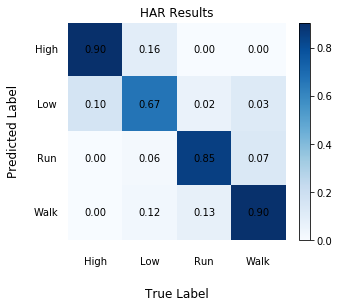

In [0]:
names = ['High', 'Low', 'Run', 'Walk']

plt.figure()
for i in range(4):
    for j in range(4):
        c = matrix[i,j]
        plt.text(i, j, ('%.2f'%c), va='center', ha='center')
        if j == 0:
          plt.text(i, j+3.9, (names[i]), va = 'center', ha = 'center')
        if i == 0:
          plt.text(i-0.9, j, (names[j]), va = 'center', ha = 'center')

plt.text(-1.5, 1.5, ('Predicted Label'), va = 'center', ha = 'center', rotation=90, fontsize = 12)
plt.text(1.5, 4.5, ('True Label'), va = 'center', ha = 'center', rotation=0, fontsize = 12)
plt.title('HAR Results')

plt.imshow(matrix, interpolation='nearest', cmap='Blues')
cbar = plt.colorbar(fraction= 0.046, pad=0.04)
cbar.set_label('', rotation=270, labelpad=30, fontsize=12)
plt.axis('off')

# Save Plot as svg file - need to edit some font colors further.
plt.savefig('/content/drive/My Drive/..../HAR_Results/Confusion_Matrix.svg', format='svg')